<img src=".\img\mioti.png">   
<br />
<center style="color:#888">Proyecto Activaciones Madrid SAMUR-PC<br/></center>

# Proyecto Activaciones Madrid SAMUR-PC: Predicciones con Prophet.

<img src=".\img\samur690.jpeg" style="width: 800px">

# Visión general del problema

* Utilizando el modelo Prophet de Facebook,vamos a predecir las activaciones que habrá hasta finales del 2022. Las predicciones que se harán seran las siguientes:

* Predicción de la activaciones SAMUR totales ( con calendario configurado ) hasta final del 2021.

* Predicciones ( con calendario configurado ) hasta final del año 2022 que incluyen:

    - Activaciones totales SAMUR.
    
    - Activaciones por tipo de código de emergencia.
    
    - Activaciones por ingresos hospitalarios.

    - Activaciones en el distrito con más activaciones SAMUR.

    - Activaciones totales en cada uno de los distritos de Madrid.

# Importación y preparación del entorno

In [1]:
#Se descargan los calendarios de festivos 
#pip install holidays

In [2]:

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 9)
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sb
from fbprophet import Prophet
rcParams.update({'font.size': 14})

# Lectura del fichero de datos

In [3]:
#Se lee el archivo de emergencias definitivo como dataframe
df_emergencias = pd.read_csv('./datos/emergencias_pp_def.csv',
                             sep=';',
                             encoding='iso8859').reset_index(drop=True)

In [4]:
#Se visualiza el dataframe ya preprocesado 
df_emergencias.tail()

,Fecha Activacion,Hora Solicitud,Hora Intervención,Código,Distrito,Hospital
556521,2021-03-31,23:33:25,NaN,Intoxicación etílica,Tetuán,Sin hospitalizacion
556522,2021-03-31,23:34:17,23:52:36,Violencia de genero,Fuencarral - El Pardo,Sin hospitalizacion
556523,2021-03-31,23:47:02,23:53:46,Agresión sexual,Tetuán,La Paz
556524,2021-03-31,23:48:18,NaN,Intoxicación etílica,Chamberí,Sin hospitalizacion
556525,2021-03-31,23:48:49,23:50:49,Intoxicación etílica,Chamberí,Sin hospitalizacion


In [5]:
df_emergencias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556526 entries, 0 to 556525
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Fecha Activacion   556526 non-null  object
 1   Hora Solicitud     556526 non-null  object
 2   Hora Intervención  508648 non-null  object
 3   Código             556374 non-null  object
 4   Distrito           556526 non-null  object
 5   Hospital           556526 non-null  object
dtypes: object(6)
memory usage: 25.5+ MB


## Preparación de los datos.

In [6]:
# Se cambia dtype de la columna a datetime
df_emergencias["Fecha Activacion"] = pd.to_datetime(
    df_emergencias["Fecha Activacion"])

In [7]:
# Se cambia el dtype de la columna a timedelta
df_emergencias["Hora Solicitud"] = pd.to_timedelta(
    df_emergencias["Hora Solicitud"])

In [8]:
# Se concatenan las dos columnas fecha activacion y hora solicitud
df_emergencias["Timestamp"] = pd.DataFrame(df_emergencias.loc[:,"Fecha Activacion"]+
df_emergencias.loc[:,"Hora Solicitud"])

In [9]:
# Se crea dataframe timeseries con fecha y hore como índices
df_timeseries_emergencias = df_emergencias.set_index("Timestamp", drop=True)

In [10]:
df_timeseries_emergencias.head()

,Fecha Activacion,Hora Solicitud,Hora Intervención,Código,Distrito,Hospital
Timestamp,,,,,,
2017-01-01 00:23:19,2017-01-01,0 days 00:23:19,0:28:59,Heridas,Centro,Concepción (Fund. J. Díaz)
2017-01-01 00:27:35,2017-01-01,0 days 00:27:35,0:35:44,Agresión sin especificar,Carabanchel,Sin hospitalizacion
2017-01-01 00:47:26,2017-01-01,0 days 00:47:26,0:55:49,Intoxicación etílica,Salamanca,Sin hospitalizacion
2017-01-01 00:55:13,2017-01-01,0 days 00:55:13,1:02:23,Agresión sin especificar,Centro,Doce de Octubre
2017-01-01 01:07:11,2017-01-01,0 days 01:07:11,1:19:44,Accidente menos de 3 victimas,Villa de Vallecas,Sin hospitalizacion


In [11]:
# Se crea dataframe para contabilizar número de emergencias por días
df_datos = df_timeseries_emergencias.groupby("Fecha Activacion").agg(
    total_emergencias=("Código", "count"))
df_datos = df_datos.reset_index()
df_datos.head()

,Fecha Activacion,total_emergencias
0,2017-01-01,432
1,2017-01-02,298
2,2017-01-03,316
3,2017-01-04,381
4,2017-01-05,369


## Adaptar los datos para el modelo.

In [12]:
# Se configura el dataframe para utilizarlo con Prophet
df_datos=df_datos.rename(columns={
    "Fecha Activacion": "ds",
    "total_emergencias": "y"
})
df_datos

,ds,y
0,2017-01-01,432
1,2017-01-02,298
2,2017-01-03,316
3,2017-01-04,381
4,2017-01-05,369
...,...,...
1542,2021-03-27,380
1543,2021-03-28,318
1544,2021-03-29,282
1545,2021-03-30,279


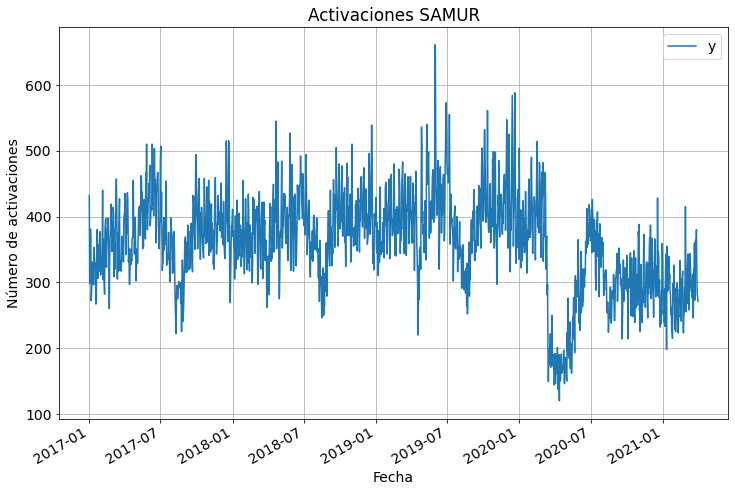

In [13]:
## Representamos nuestra serie temporal con la variable de salida y (número total de emergencias)
ax = df_datos.set_index("ds").plot(figsize=(12, 8),title="Activaciones SAMUR")
ax.set_ylabel('Número de activaciones')
ax.set_xlabel('Fecha')
ax.grid()
plt.show()

# Aplicación del modelo predictivo con Prophet



## Configuración del calendario para el modelo.

Predicción con calendario configurado hasta final de 2021.
En este apartado se van a crear y tener en cuenta  los periodos significativos que se han producido en el pasado y que se deben tener en cuenta en el modelo Prophet para predecir las futuras activaciones de emergencias.
Se tendrá en cuenta tres periodos muy significativos de gran impacto en la actividad socioeconómica:

* El confinamiento general de la población por el estado de alarma en España debido a la pademia del COVID-19.
* El periodo que comprende  el toque de queda gestionado por las CCAA.
* El periodo que comienza con el fin del confinamiento, llamado de "nueva normalidad".

También hemos tenido en cuenta en el calendario la borrasca "Filomena", que tanto efecto adverso tuvo en Madrid, y se ha incluido abriendo un "hueco" en el periodo del toque de queda para poder introducirlo en el calendario del modelo. 

**Nota**: Entendemos que el modelo debe diferenciarlos por la diferente afectación que ha mostrado en la serie temporal.

In [14]:
# Se crea primer evento especial( Confinamiento General del País)
confinamiento_general = pd.DataFrame({
    "holiday":
    "alarma_1",
    "ds":
    pd.date_range(start="2020-03-15", end="2020-06-21", freq="D"),
    "lower_window":
    0,
    "upper_window":
    1
})

In [15]:
confinamiento_general

,holiday,ds,lower_window,upper_window
0,alarma_1,2020-03-15,0,1
1,alarma_1,2020-03-16,0,1
2,alarma_1,2020-03-17,0,1
3,alarma_1,2020-03-18,0,1
4,alarma_1,2020-03-19,0,1
...,...,...,...,...
94,alarma_1,2020-06-17,0,1
95,alarma_1,2020-06-18,0,1
96,alarma_1,2020-06-19,0,1
97,alarma_1,2020-06-20,0,1


In [16]:
nueva_normalidad = pd.DataFrame({
    "holiday":
    "normalidad",
    "ds":
    pd.date_range(start="2020-06-22", end="2020-10-31", freq="D"),
    "lower_window":
    0,
    "upper_window":
    1
})

In [17]:
# Se crea segundo evento especial ( Toque de queda CCAA) primero.
#Este tipo de evento es de naturaleza diferente del anterior(confinamiento general)
# Se crea con otro nombre para que el modelo lo trate de modo diferente
toque_de_queda = pd.DataFrame({
    "holiday":
    "toque",
    "ds":
    pd.date_range(start="2020-11-01", end="2021-01-05", freq="D"),
    "lower_window":
    0,
    "upper_window":
    1
})


In [18]:
toque_de_queda

,holiday,ds,lower_window,upper_window
0,toque,2020-11-01,0,1
1,toque,2020-11-02,0,1
2,toque,2020-11-03,0,1
3,toque,2020-11-04,0,1
4,toque,2020-11-05,0,1
...,...,...,...,...
61,toque,2021-01-01,0,1
62,toque,2021-01-02,0,1
63,toque,2021-01-03,0,1
64,toque,2021-01-04,0,1


In [19]:
#Se crea como evento especial el fenómeno meteorológico filomena
filomena = pd.DataFrame({
    "holiday":
    "filomena",
    "ds":
    pd.date_range(start="2021-01-06", end="2021-01-15", freq="D"),
    "lower_window":
    0,
    "upper_window":
    1
})

In [20]:
filomena

,holiday,ds,lower_window,upper_window
0,filomena,2021-01-06,0,1
1,filomena,2021-01-07,0,1
2,filomena,2021-01-08,0,1
3,filomena,2021-01-09,0,1
4,filomena,2021-01-10,0,1
5,filomena,2021-01-11,0,1
6,filomena,2021-01-12,0,1
7,filomena,2021-01-13,0,1
8,filomena,2021-01-14,0,1
9,filomena,2021-01-15,0,1


In [21]:
#Se continua con este evento el mismo toque de queda de las CCAA
toque_de_queda_con = pd.DataFrame({
    "holiday":
    "toque",
    "ds":
    pd.date_range(start="2021-01-16", end="2021-05-01", freq="D"),
    "lower_window":
    0,
    "upper_window":
    1
})

In [22]:
toque_de_queda_con

,holiday,ds,lower_window,upper_window
0,toque,2021-01-16,0,1
1,toque,2021-01-17,0,1
2,toque,2021-01-18,0,1
3,toque,2021-01-19,0,1
4,toque,2021-01-20,0,1
...,...,...,...,...
101,toque,2021-04-27,0,1
102,toque,2021-04-28,0,1
103,toque,2021-04-29,0,1
104,toque,2021-04-30,0,1


In [23]:
#Se concatenan los dataframes en uno solo de días especiales
dias_especiales = pd.concat(
    [confinamiento_general,toque_de_queda,nueva_normalidad,toque_de_queda_con,filomena])
dias_especiales = dias_especiales.reset_index(drop=True)
dias_especiales

,holiday,ds,lower_window,upper_window
0,alarma_1,2020-03-15,0,1
1,alarma_1,2020-03-16,0,1
2,alarma_1,2020-03-17,0,1
3,alarma_1,2020-03-18,0,1
4,alarma_1,2020-03-19,0,1
...,...,...,...,...
408,filomena,2021-01-11,0,1
409,filomena,2021-01-12,0,1
410,filomena,2021-01-13,0,1
411,filomena,2021-01-14,0,1


### Transformación logarítmica.

Se realiza una transformación logarítmica a los datos para evitar que nos salgan resultados con valores negativos.

In [24]:
df_datos["y"]=np.log2(df_datos["y"])
df_datos

,ds,y
0,2017-01-01,8.754888
1,2017-01-02,8.219169
2,2017-01-03,8.303781
3,2017-01-04,8.573647
4,2017-01-05,8.527477
...,...,...
1542,2021-03-27,8.569856
1543,2021-03-28,8.312883
1544,2021-03-29,8.139551
1545,2021-03-30,8.124121


## Aplicación del modelo con el calendario.

In [25]:
modelo = Prophet(holidays=dias_especiales)
#Nos descargamos el calendario de festivos españoles
modelo.add_country_holidays(country_name='ESP')
modelo.fit(df_datos)

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
#Se crea el dataframe a futuro hasta donde queramos predecir
# Es este primer caso,lo hacemos hasta final del 2021
futuro_21 = modelo.make_future_dataframe(periods=275)
futuro_21

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05
...,...
1817,2021-12-27
1818,2021-12-28
1819,2021-12-29
1820,2021-12-30


In [27]:
prediccion=modelo.predict(futuro_21)

In [28]:
prediccion.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Asunción de la Virgen,Asunción de la Virgen_lower,Asunción de la Virgen_upper,Asunción de la Virgen (Trasladado),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1817,2021-12-27,8.641803,8.249710,8.949058,8.350453,8.925312,0.0,0.0,0.0,0.0,...,-0.046917,-0.046917,-0.046917,-0.004895,-0.004895,-0.004895,0.0,0.0,0.0,8.589990
1818,2021-12-28,8.641304,8.194599,8.881215,8.348284,8.926192,0.0,0.0,0.0,0.0,...,-0.089850,-0.089850,-0.089850,-0.017270,-0.017270,-0.017270,0.0,0.0,0.0,8.534184
1819,2021-12-29,8.640806,8.178442,8.925036,8.346601,8.927010,0.0,0.0,0.0,0.0,...,-0.063393,-0.063393,-0.063393,-0.029485,-0.029485,-0.029485,0.0,0.0,0.0,8.547927
1820,2021-12-30,8.640307,8.200703,8.914158,8.345103,8.927796,0.0,0.0,0.0,0.0,...,-0.038445,-0.038445,-0.038445,-0.041394,-0.041394,-0.041394,0.0,0.0,0.0,8.560468
1821,2021-12-31,8.639809,8.303946,9.049681,8.343061,8.928582,0.0,0.0,0.0,0.0,...,0.077125,0.077125,0.077125,-0.052853,-0.052853,-0.052853,0.0,0.0,0.0,8.664081


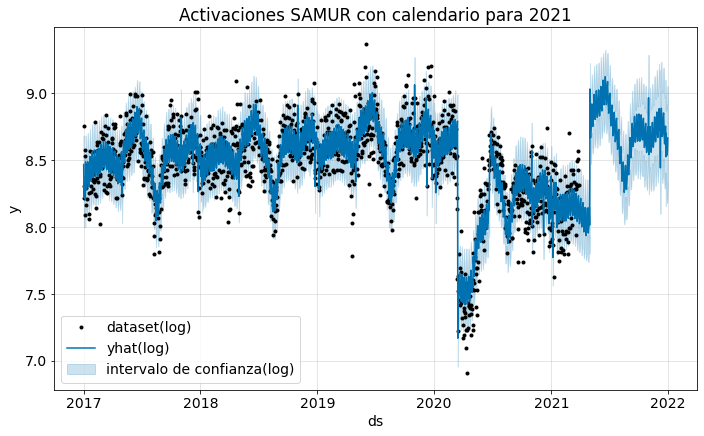

In [29]:
#Plot a escala logarítmica
modelo.plot(prediccion)
plt.legend(["dataset(log)","yhat(log)","intervalo de confianza(log)"])
plt.title("Activaciones SAMUR con calendario para 2021");

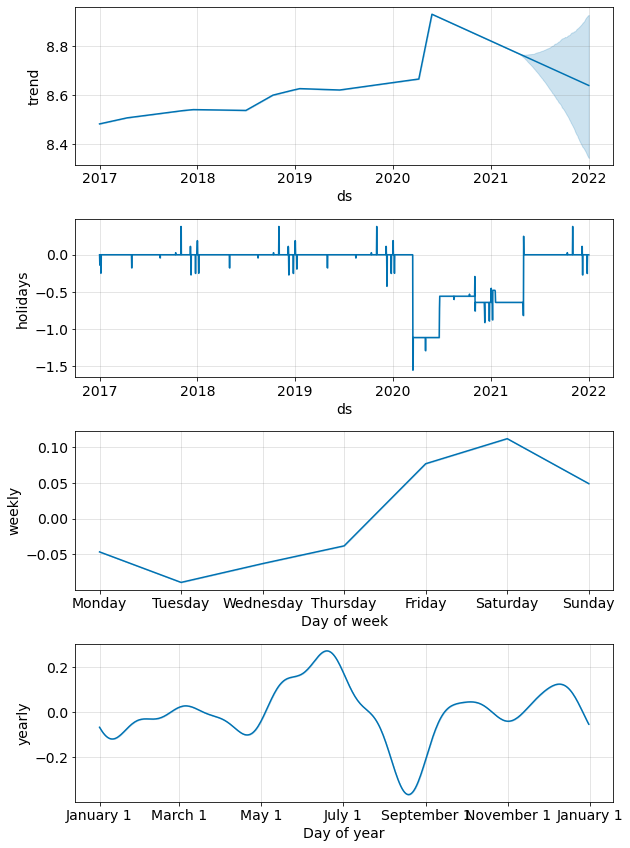

In [30]:
modelo.plot_components(prediccion, weekly_start = 1);

### Preparación de los resultados.Transformación exponencial.

Una vez obtenido las predicciones se le aplica la exponencial 2 solamente a los datos de la columna yhat (dato que nos interesa) para el resultado final de la predicción total de activaciones.

In [31]:
prediccion["yhat"]=np.exp2(prediccion["yhat"])

In [32]:
prediccion["yhat"]

0       353.425770
1       298.115145
2       316.868503
3       320.978387
4       325.039593
           ...    
1817    385.340477
1818    370.719400
1819    374.267815
1820    377.535269
1821    405.647021
Name: yhat, Length: 1822, dtype: float64

In [33]:
total_pre_2021=prediccion["yhat"][-365:].sum()
print(f"La predicción para el 2021 será de {round(total_pre_2021)} activaciones.")

La predicción para el 2021 será de 137546 activaciones.


# Predicción con calendario  hasta final del 2022.

## Predicción de las todas las activaciones SAMUR.

En este apartado, vamos a predecir el total de activaciones SAMUR que se producirán para el año 2022 en Madrid. Se aplicará al modelo el calendario configurado con los periodos significativos ya descritos.

### Aplicación del modelo.

In [34]:
#Se define nuevo modelo
modelo2 = Prophet(holidays=dias_especiales)
modelo2.add_country_holidays(country_name='ESP')
modelo2.fit(df_datos)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
#Se crea dataframe futuro hasta final del 2022
futuro_22 = modelo2.make_future_dataframe(periods=640)
futuro_22

,ds
0,2017-01-01
1,2017-01-02
2,2017-01-03
3,2017-01-04
4,2017-01-05
...,...
2182,2022-12-27
2183,2022-12-28
2184,2022-12-29
2185,2022-12-30


In [36]:
#Se realiza predicción de las emergencias hasta finales de 2022
prediccion2 = modelo2.predict(futuro_22)

In [37]:
prediccion2.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Asunción de la Virgen,Asunción de la Virgen_lower,Asunción de la Virgen_upper,Asunción de la Virgen (Trasladado),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2182,2022-12-27,8.459870,7.260028,9.465041,7.376505,9.516345,0.0,0.0,0.0,0.0,...,-0.089850,-0.089850,-0.089850,-0.001794,-0.001794,-0.001794,0.0,0.0,0.0,8.368226
2183,2022-12-28,8.459372,7.250509,9.480030,7.373904,9.519096,0.0,0.0,0.0,0.0,...,-0.063393,-0.063393,-0.063393,-0.014186,-0.014186,-0.014186,0.0,0.0,0.0,8.381793
2184,2022-12-29,8.458873,7.239008,9.513165,7.371303,9.521739,0.0,0.0,0.0,0.0,...,-0.038445,-0.038445,-0.038445,-0.026455,-0.026455,-0.026455,0.0,0.0,0.0,8.393974
2185,2022-12-30,8.458375,7.373238,9.619578,7.368702,9.525292,0.0,0.0,0.0,0.0,...,0.077125,0.077125,0.077125,-0.038454,-0.038454,-0.038454,0.0,0.0,0.0,8.497046
2186,2022-12-31,8.457877,7.404285,9.632629,7.366101,9.528845,0.0,0.0,0.0,0.0,...,0.112348,0.112348,0.112348,-0.050038,-0.050038,-0.050038,0.0,0.0,0.0,8.520187


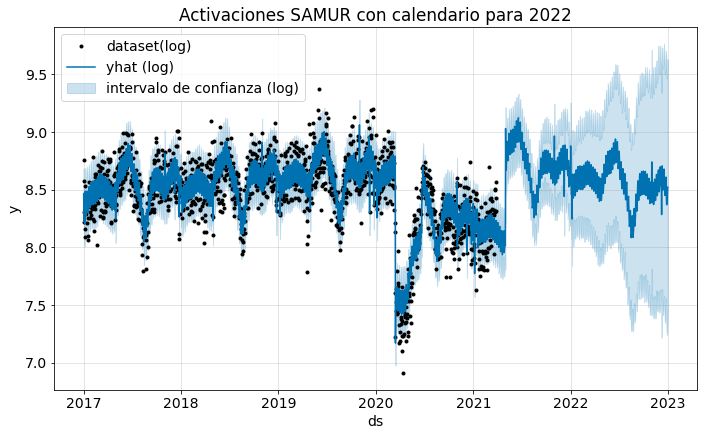

In [38]:
#Se muestra plot a escala logarítmica
modelo2.plot(prediccion2)
plt.legend(["dataset(log)", "yhat (log)", "intervalo de confianza (log)"],loc="upper left")

plt.title(
    "Activaciones SAMUR con calendario para 2022");

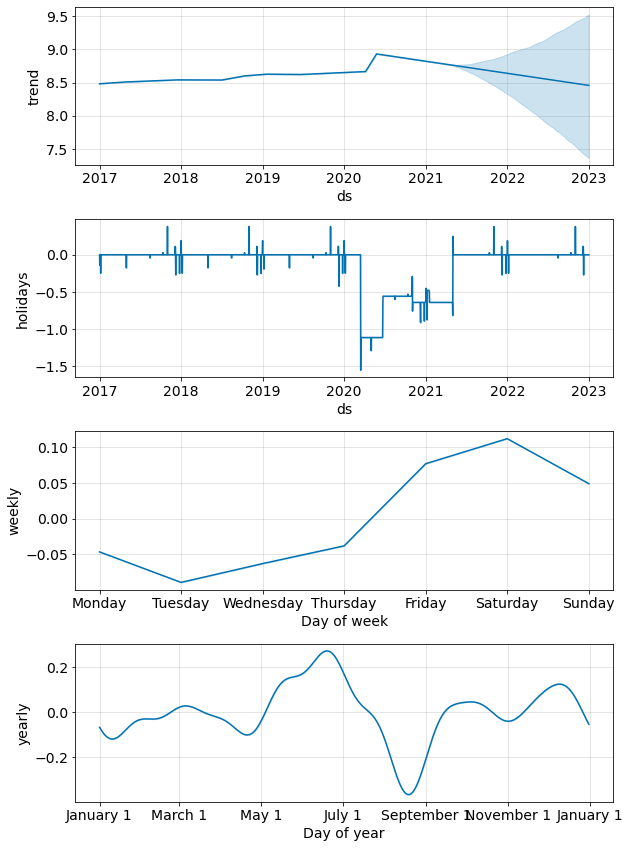

In [39]:
modelo2.plot_components(prediccion2, weekly_start=1);

### Preparación de los resultados.Transformación exponencial.

Una vez hecha la predicción con la aplicación del modelo, le aplicamos la exponente 2 a todos los valores de la columna yhat (valores de predicción) para obtener los valores reales porque estaban a escala logarítmica. 

In [40]:
prediccion2["yhat"]=np.exp2(prediccion2["yhat"])
total_pre_2022=prediccion2["yhat"][-365:].sum()

In [41]:
print(f"Las activaciones totales que se predicen para el año 2022 serán de {round(total_pre_2022)} activaciones.")

Las activaciones totales que se predicen para el año 2022 serán de 137513 activaciones.


### Rango de confianza.

Se muestran por medio de histogramas la frecuencia de los  rangos en los que se están moviendo los valores predichos  (yhat).

array([[<AxesSubplot:title={'center':'yhat_lower'}>,
        <AxesSubplot:title={'center':'yhat_upper'}>]], dtype=object)

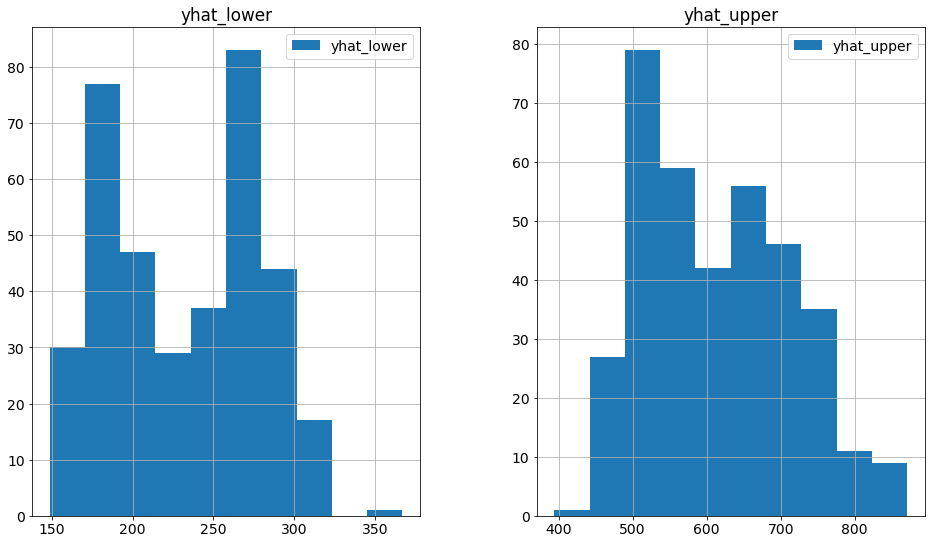

In [42]:
#Se plotea con histogramas  los valores inferiores y superiores en los que se mueve los valores predichos(yhat)
rangos = np.exp2(prediccion2[["yhat_lower",
                              "yhat_upper"]][-365:]).hist(legend=True)
rangos

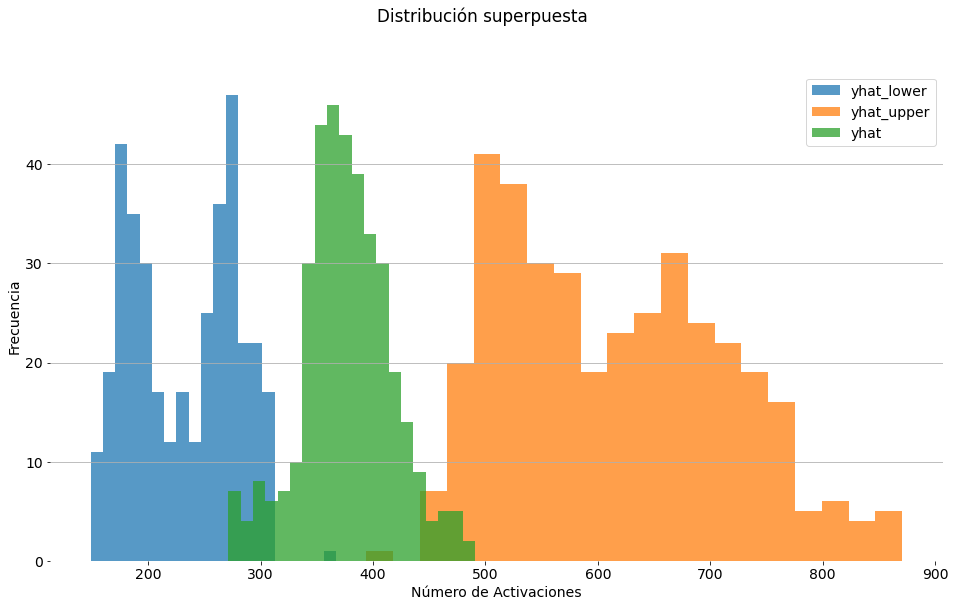

In [43]:
fig, ax = plt.subplots()

# Representamos el histograma 
ax.hist(np.exp2(prediccion2["yhat_lower"][-365:]), bins=20, label="yhat_lower", alpha=.75)

# Representamos el histograma 
ax.hist(np.exp2(prediccion2["yhat_upper"][-365:]), bins=20, label="yhat_upper", alpha=.75)
ax.hist(prediccion2["yhat"][-365:],bins=20,label="yhat",alpha=.75)
ax.legend()

ax.grid(True, axis='y')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xlabel('Número de Activaciones')
ax.set_ylabel('Frecuencia')
fig.suptitle('Distribución superpuesta');

In [44]:
#Se calcula la media de los valores por lo bajo y por lo alto
media_rangos=np.exp2(prediccion2[["yhat_lower","yhat_upper"]][-365:]).mean()
media_rangos

yhat_lower    232.174267
yhat_upper    614.142137
dtype: float64

## Predicción por tipo de activación más frecuente.

Como gran número de tipos de activación (94) se opta por buscar los dos tipos más frecuentes de activación, para predecir como se van a comportar estos tipos en 2022.

### Selección de los datos.

In [45]:
#Se comprueba cuales son las emergencias más frecuentes
df_emergencias["Código"].value_counts(normalize=True)


Casual: caída, etc                                               0.170269
Patología cardiovascular                                         0.164699
Intoxicación etílica                                             0.078336
Accidente menos de 3 victimas                                    0.050910
Agresión sin especificar                                         0.050552
                                                                   ...   
Atención psicológica a intervinientes de Bomberos.               0.000002
No suceso                                                        0.000002
Persona sin techo fallecida en vía pública                     0.000002
Acc. Trasp. Merc. Peligrosas                                     0.000002
Atención psicológica a intervinientes de Cuerpos de Seguridad    0.000002
Name: Código, Length: 94, dtype: float64

In [46]:
#Se dataframe para prophet con las columnas que se requieren, la variable de salida será un tipo de  emergencia
#El tipo de emergencia como variable de salida será Intoxicación etílica
df_emerg_casual = df_emergencias[df_emergencias["Código"] ==
                                 "Casual: caída, etc"]
df_emerg_casual = df_emerg_casual[["Fecha Activacion", "Código"]]
df_grouped_casual = df_emerg_casual.groupby(
    "Fecha Activacion").count().reset_index()
df_grouped_casual

,Fecha Activacion,Código
0,2017-01-01,55
1,2017-01-02,68
2,2017-01-03,68
3,2017-01-04,97
4,2017-01-05,72
...,...,...
1542,2021-03-27,59
1543,2021-03-28,49
1544,2021-03-29,49
1545,2021-03-30,53


### Adaptación de los datos al modelo.

In [47]:
# Se renombra las columnas para poder utilizar el dataframe con prophet
df_grouped_casual=df_grouped_casual.rename(columns={"Fecha Activacion":"ds","Código":"y"})
df_grouped_casual

,ds,y
0,2017-01-01,55
1,2017-01-02,68
2,2017-01-03,68
3,2017-01-04,97
4,2017-01-05,72
...,...,...
1542,2021-03-27,59
1543,2021-03-28,49
1544,2021-03-29,49
1545,2021-03-30,53


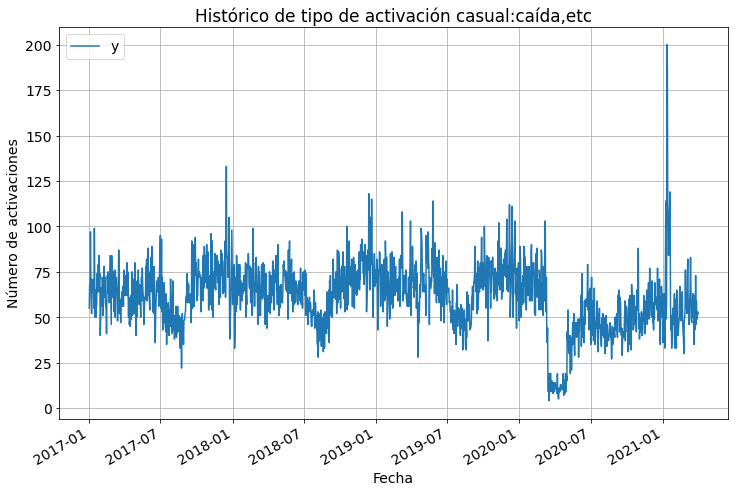

In [48]:
## Representamos nuestra serie temporal con la variable de salida y (número de emergencias)
ax = df_grouped_casual.set_index("ds").plot(
    title="Histórico de tipo de activación casual:caída,etc", figsize=(12, 8))
ax.set_ylabel('Número de activaciones')
ax.set_xlabel('Fecha')
ax.grid()
plt.show()

#### Configuración del calendario para el modelo.

Para este tipo de predicción se configura un nuevo calendario por las características diferentes de una activación en particular.

In [49]:
# Se crea primer evento especial( Confinamiento General del País)
confinamiento_general = pd.DataFrame({
    "holiday":
    "alarma_1",
    "ds":
    pd.date_range(start="2020-03-15", end="2020-06-21", freq="D"),
    "lower_window":
    0,
    "upper_window":
    1
})

In [50]:
confinamiento_general

,holiday,ds,lower_window,upper_window
0,alarma_1,2020-03-15,0,1
1,alarma_1,2020-03-16,0,1
2,alarma_1,2020-03-17,0,1
3,alarma_1,2020-03-18,0,1
4,alarma_1,2020-03-19,0,1
...,...,...,...,...
94,alarma_1,2020-06-17,0,1
95,alarma_1,2020-06-18,0,1
96,alarma_1,2020-06-19,0,1
97,alarma_1,2020-06-20,0,1


In [51]:
nueva_normalidad = pd.DataFrame({
    "holiday":
    "normalidad",
    "ds":
    pd.date_range(start="2020-06-22", end="2020-10-31", freq="D"),
    "lower_window":
    0,
    "upper_window":
    1
})

In [52]:
nueva_normalidad

,holiday,ds,lower_window,upper_window
0,normalidad,2020-06-22,0,1
1,normalidad,2020-06-23,0,1
2,normalidad,2020-06-24,0,1
3,normalidad,2020-06-25,0,1
4,normalidad,2020-06-26,0,1
...,...,...,...,...
127,normalidad,2020-10-27,0,1
128,normalidad,2020-10-28,0,1
129,normalidad,2020-10-29,0,1
130,normalidad,2020-10-30,0,1


In [53]:
#Se crea como evento especial el fenómeno meteorológico filomena
filomena = pd.DataFrame({
    "holiday":
    "filomena",
    "ds":
    pd.date_range(start="2021-01-06", end="2021-01-15", freq="D"),
    "lower_window":
    0,
    "upper_window":
    1
})

In [54]:
filomena

,holiday,ds,lower_window,upper_window
0,filomena,2021-01-06,0,1
1,filomena,2021-01-07,0,1
2,filomena,2021-01-08,0,1
3,filomena,2021-01-09,0,1
4,filomena,2021-01-10,0,1
5,filomena,2021-01-11,0,1
6,filomena,2021-01-12,0,1
7,filomena,2021-01-13,0,1
8,filomena,2021-01-14,0,1
9,filomena,2021-01-15,0,1


In [55]:
#Se concatenan los dataframes en uno solo de días especiales
dias_especiales_caida = pd.concat(
    [confinamiento_general,nueva_normalidad, filomena])
dias_especiales_caida = dias_especiales_caida.reset_index(drop=True)
dias_especiales_caida

,holiday,ds,lower_window,upper_window
0,alarma_1,2020-03-15,0,1
1,alarma_1,2020-03-16,0,1
2,alarma_1,2020-03-17,0,1
3,alarma_1,2020-03-18,0,1
4,alarma_1,2020-03-19,0,1
...,...,...,...,...
236,filomena,2021-01-11,0,1
237,filomena,2021-01-12,0,1
238,filomena,2021-01-13,0,1
239,filomena,2021-01-14,0,1


#### Transformación logarítmica.

In [56]:
df_grouped_casual["y"]=np.log2(df_grouped_casual["y"])

In [57]:
df_grouped_casual.head()

,ds,y
0,2017-01-01,5.781360
1,2017-01-02,6.087463
2,2017-01-03,6.087463
3,2017-01-04,6.599913
4,2017-01-05,6.169925


### Aplicación del modelo.

In [58]:
#Se crea nuevo modelo para poder volver a entrenarlo
modelo3=Prophet(holidays=dias_especiales_caida)
modelo3.add_country_holidays(country_name='ESP')

In [59]:
#Se realiza predicción para un tipo de  emergencia 
prediccion3 = modelo3.fit(df_grouped_casual).predict(futuro_22)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


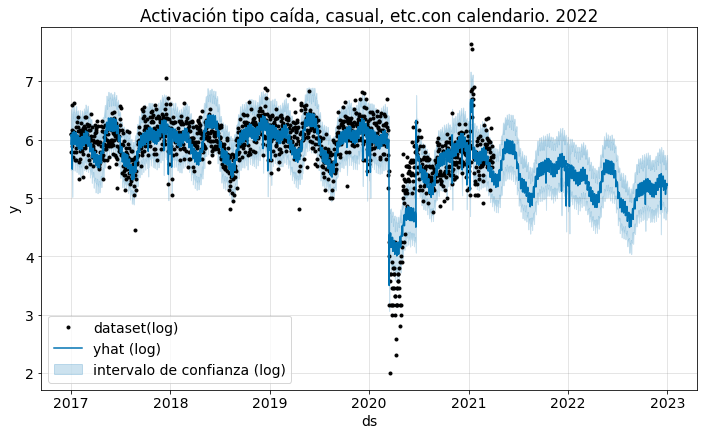

In [60]:
#Se plotea los resultados de la predicción
modelo3.plot(prediccion3)
plt.legend(["dataset(log)", "yhat (log)", "intervalo de confianza (log)"],loc="lower left")
plt.title("Activación tipo caída, casual, etc.con calendario. 2022");

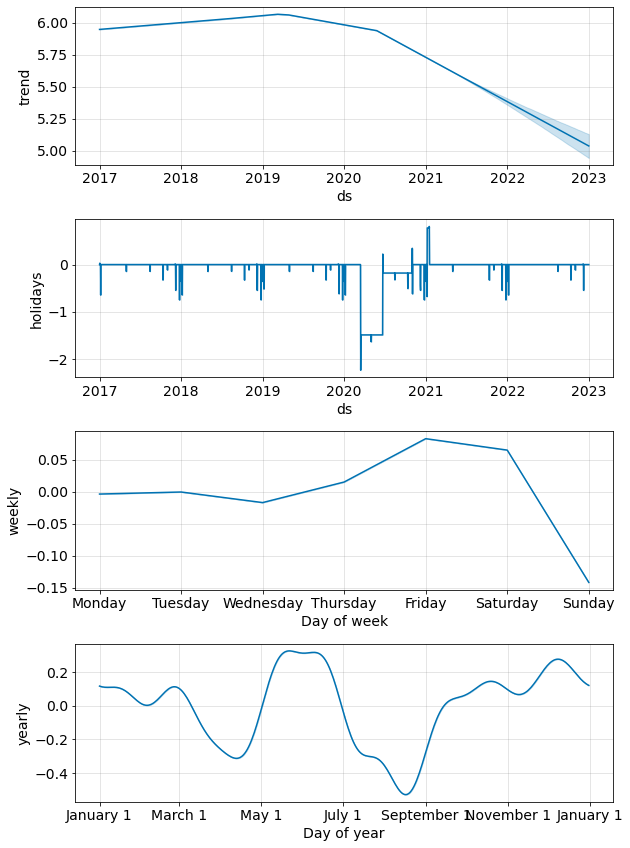

In [61]:
modelo3.plot_components(prediccion3, weekly_start=1);

### Preparación de los resultados. Transformación exponencial.

In [62]:
prediccion3["yhat"]=np.exp2(prediccion3["yhat"])

In [63]:
total_casual_2022=prediccion3["yhat"][-365:].sum()
print(f"La predicción de las activaciones por tipo casual para el 2022 serán de {round(total_casual_2022)} activaciones.")

La predicción de las activaciones por tipo casual para el 2022 serán de 13655 activaciones.


## Predicción por activación tipo cardiovascular.

### Selección de los datos.

In [64]:
#Se crea dataframe con los datos de la patología cardivascular
df_emerg_cardio = df_emergencias[df_emergencias["Código"] ==
                                "Patología cardiovascular"]
df_emerg_cardio=df_emerg_cardio[["Fecha Activacion","Código"]]
df_grouped_cardio=df_emerg_cardio.groupby("Fecha Activacion").count().reset_index()
df_grouped_cardio

,Fecha Activacion,Código
0,2017-01-01,29
1,2017-01-02,60
2,2017-01-03,83
3,2017-01-04,68
4,2017-01-05,61
...,...,...
1542,2021-03-27,53
1543,2021-03-28,51
1544,2021-03-29,53
1545,2021-03-30,38


### Adaptación de los datos para el modelo.

In [65]:
#Se renombran las columnas para aplicar el dataframe a prophet
df_grouped_cardio=df_grouped_cardio.rename(columns={"Fecha Activacion":"ds","Código":"y"})
df_grouped_cardio

,ds,y
0,2017-01-01,29
1,2017-01-02,60
2,2017-01-03,83
3,2017-01-04,68
4,2017-01-05,61
...,...,...
1542,2021-03-27,53
1543,2021-03-28,51
1544,2021-03-29,53
1545,2021-03-30,38


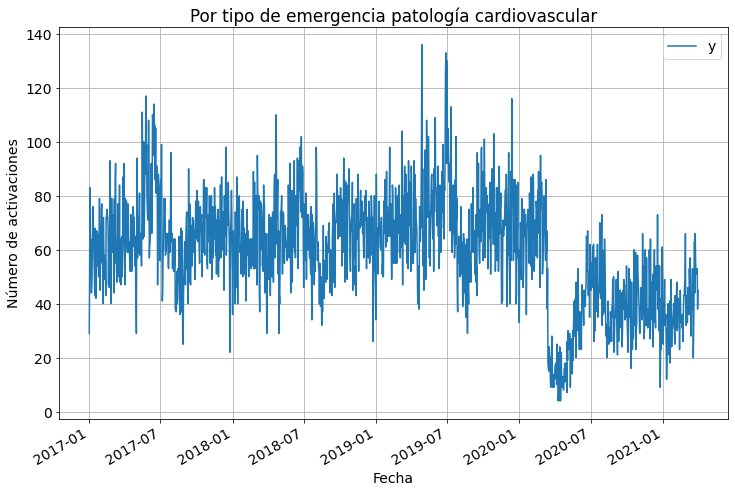

In [66]:
## Representamos nuestra serie temporal con la variable de salida y (número de emergencias)
ax = df_grouped_cardio.set_index("ds").plot(
    title="Por tipo de emergencia patología cardiovascular", figsize=(12, 8))
ax.set_ylabel('Número de activaciones')
ax.set_xlabel('Fecha')
ax.grid()
plt.show()

#### Transformación logarítmica

In [67]:
df_grouped_cardio["y"]= np.log2(df_grouped_cardio["y"])

#### Calendario para el modelo.

In [68]:
dias_especiales_cardio = pd.concat([
    confinamiento_general, nueva_normalidad,toque_de_queda,filomena,toque_de_queda_con
])
dias_especiales_cardio = dias_especiales_cardio.reset_index(drop=True)
dias_especiales_cardio

,holiday,ds,lower_window,upper_window
0,alarma_1,2020-03-15,0,1
1,alarma_1,2020-03-16,0,1
2,alarma_1,2020-03-17,0,1
3,alarma_1,2020-03-18,0,1
4,alarma_1,2020-03-19,0,1
...,...,...,...,...
408,toque,2021-04-27,0,1
409,toque,2021-04-28,0,1
410,toque,2021-04-29,0,1
411,toque,2021-04-30,0,1


### Aplicación del modelo.

In [69]:
modelo4=Prophet(holidays=dias_especiales_cardio)
modelo4.add_country_holidays(country_name='ESP')

In [70]:
prediccion4 = modelo4.fit(df_grouped_cardio).predict(futuro_22)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


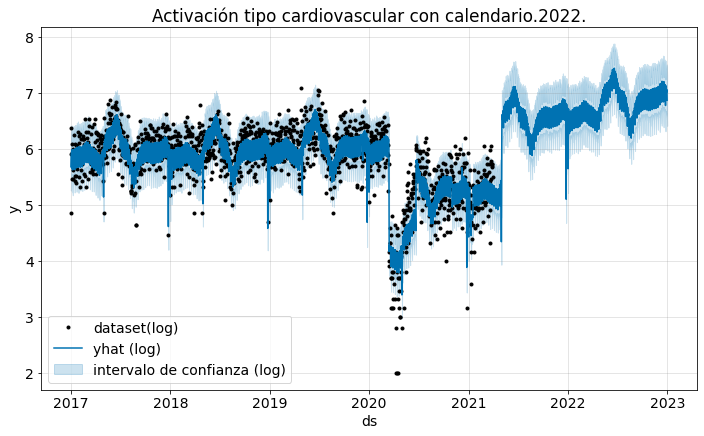

In [71]:
modelo4.plot(prediccion4)
plt.legend(["dataset(log)", "yhat (log)", "intervalo de confianza (log)"],loc="lower left")
plt.title("Activación tipo cardiovascular con calendario.2022.");

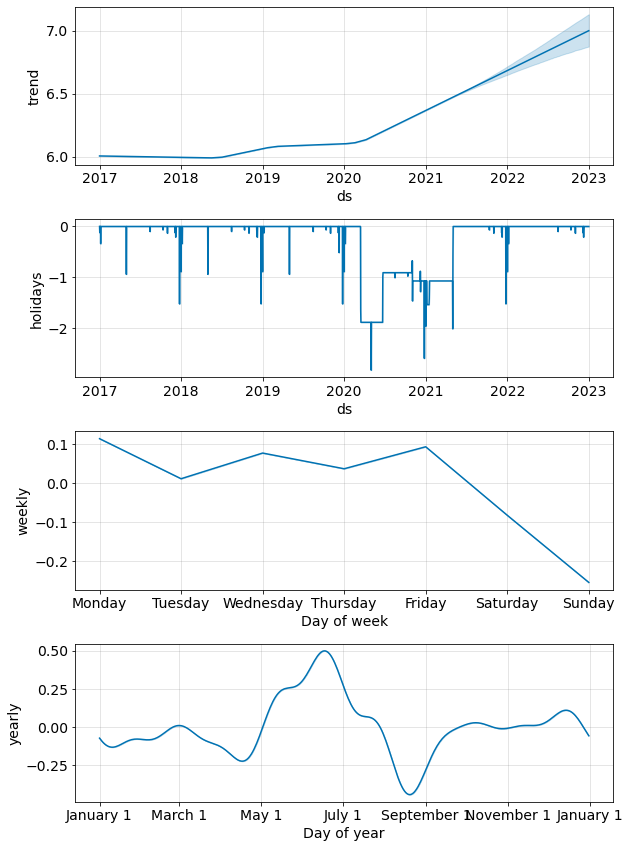

In [72]:
modelo4.plot_components(prediccion4, weekly_start=1);

### Preparación de los resultados. Transformación exponencial.

In [73]:
prediccion4["yhat"]=np.exp2(prediccion4["yhat"])

In [74]:
total_cardio_2022 = prediccion4["yhat"][-365:].sum()
print(
    f" La predicción de las activaciones  por tipo  cardiovascular  para  el año 2022  serán de {round(total_cardio_2022)} activaciones"
)

 La predicción de las activaciones  por tipo  cardiovascular  para  el año 2022  serán de 42369 activaciones


## Predicción de ingresos en el Hospital con más ingresos.

En este apartado, vamos a predecir los ingresos hospitalarios en el hospital que más hospitalizaciones tiene en el histórico del dataset y queremos predecir como va a ser este dato para el año 2022.

### Selección de los datos.

In [75]:
#Se muestran los hospitales con mas datos de ingresos hospitalarios
df_emergencias["Hospital"].value_counts().head()

Sin hospitalizacion           381150
Gregorio Marañón               28497
Doce de Octubre                26521
Concepción (Fund. J. Díaz)     25919
La Paz                         21448
Name: Hospital, dtype: int64

In [76]:
df_hosp_gregorio = df_emergencias[df_emergencias["Hospital"] ==
                                  "Gregorio Marañón"]
df_hosp_gregorio_grouped=df_hosp_gregorio.groupby("Fecha Activacion").agg(ingresos=("Hospital","count")).reset_index()
df_hosp_gregorio_grouped.head()

,Fecha Activacion,ingresos
0,2017-01-01,17
1,2017-01-02,23
2,2017-01-03,15
3,2017-01-04,24
4,2017-01-05,18


### Adaptación de los datos para el modelo.

In [77]:
df_datos_gregorio = df_hosp_gregorio_grouped.rename(columns={
    "Fecha Activacion": "ds",
    "ingresos": "y"
})
df_datos_gregorio.head()

,ds,y
0,2017-01-01,17
1,2017-01-02,23
2,2017-01-03,15
3,2017-01-04,24
4,2017-01-05,18


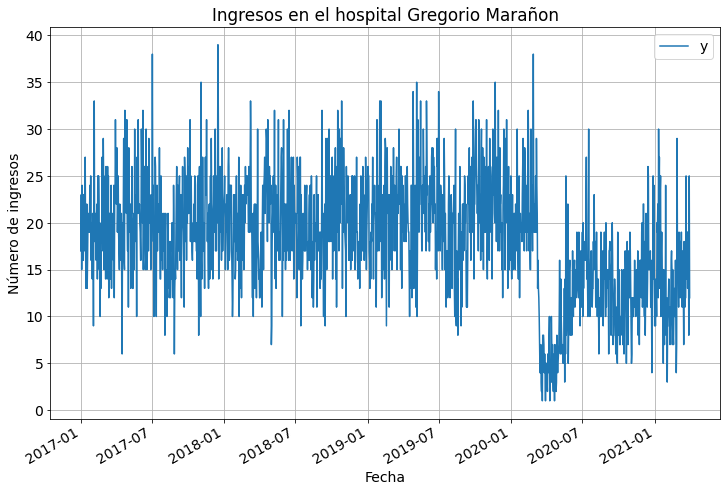

In [78]:
## Representamos nuestra serie temporal con la variable de salida y (número de emergencias)
ax = df_datos_gregorio.set_index("ds").plot(
    title="Ingresos en el hospital Gregorio Marañon", figsize=(12, 8))
ax.set_ylabel('Número de ingresos')
ax.set_xlabel('Fecha')
ax.grid()
plt.show()

#### Transformación logarítmica

In [79]:
df_datos_gregorio["y"]=np.log2(df_datos_gregorio["y"])

#### Configuración del calendario para el modelo.

En este tipo de predicción se opta por dejar la misma configuración del calendario que en el caso de las activaciones totales porque los ingresos hospitalarios proceden de todas los tipos de activaciones y debemos mantener en este caso el mismo criterio.

### Aplicación del modelo.

In [80]:
modelo5=Prophet(holidays=dias_especiales)
modelo5.add_country_holidays(country_name='ESP')

In [81]:
prediccion5 = modelo5.fit(df_datos_gregorio).predict(futuro_22)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


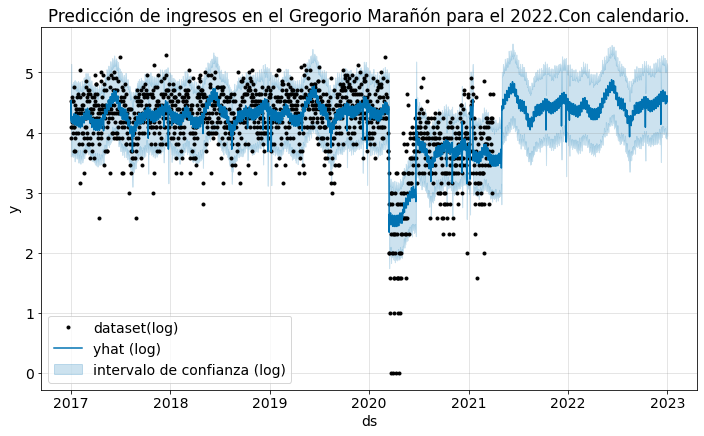

In [82]:
modelo5.plot(prediccion5)
plt.legend(["dataset(log)", "yhat (log)", "intervalo de confianza (log)"],loc="lower left")
plt.title("Predicción de ingresos en el Gregorio Marañón para el 2022.Con calendario.");

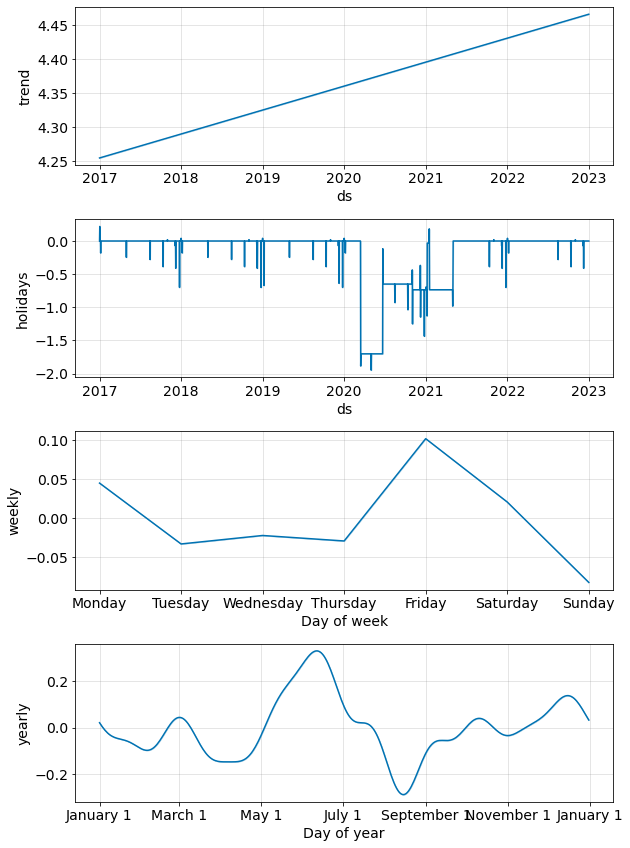

In [83]:
modelo5.plot_components(prediccion5, weekly_start=1);

### Preparación de los resultados. Transformación exponencial.

In [84]:
prediccion5["yhat"]=np.exp2(prediccion5["yhat"])

In [85]:
total_ingresos_2022 = prediccion5["yhat"][-365:].sum()
print(
    f"La predicción de los ingresos en el Hospital Gregorio Marañón para el 2022 serán de {(round(total_ingresos_2022))} ingresos."
)

La predicción de los ingresos en el Hospital Gregorio Marañón para el 2022 serán de 7996 ingresos.


## Predicción por distrito con más activaciones.

En este apartado, las predicciones que se van a realizar seran sobre las emergencias para el año 2022 en el  distrito con más activaciones en el dataset.

### Preparación de los datos.

In [86]:
#Se muestran los distritos con más emergencias
df_emergencias["Distrito"].value_counts().head()

Centro                80497
Carabanchel           38472
Puente de Vallecas    34479
Moncloa - Aravaca     34099
Latina                32722
Name: Distrito, dtype: int64

In [87]:
df_emerg_centro = df_emergencias[df_emergencias["Distrito"] == "Centro"]
df_datos_centro = df_emerg_centro.groupby("Fecha Activacion").agg(
    emergencias=("Distrito", "count")).reset_index()
df_datos_centro.head()

,Fecha Activacion,emergencias
0,2017-01-01,74
1,2017-01-02,46
2,2017-01-03,50
3,2017-01-04,74
4,2017-01-05,62


In [88]:
df_datos_centro=df_datos_centro.rename(columns={"Fecha Activacion":"ds","emergencias":"y"})
df_datos_centro

,ds,y
0,2017-01-01,74
1,2017-01-02,46
2,2017-01-03,50
3,2017-01-04,74
4,2017-01-05,62
...,...,...
1542,2021-03-27,52
1543,2021-03-28,38
1544,2021-03-29,41
1545,2021-03-30,39


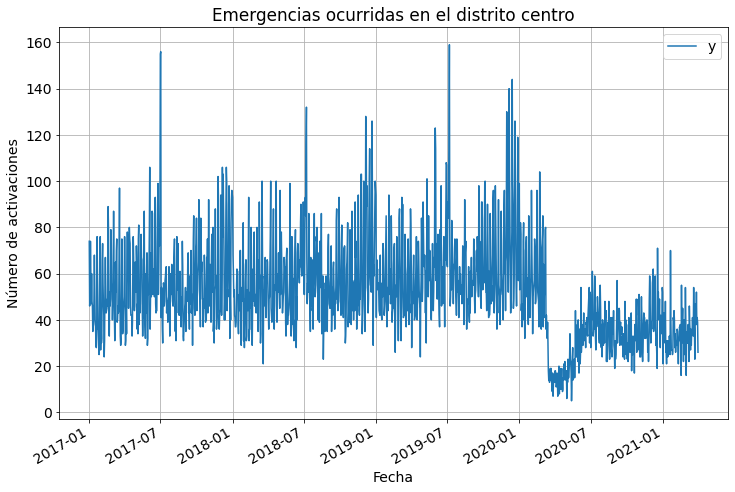

In [89]:
## Representamos nuestra serie temporal con la variable de salida y (número de emergencias)
ax = df_datos_centro.set_index("ds").plot(
    title="Emergencias ocurridas en el distrito centro", figsize=(12, 8))
ax.set_ylabel('Número de activaciones')
ax.set_xlabel('Fecha')
ax.grid()
plt.show()

### Transformación logarítmica.

In [90]:
df_datos_centro["y"]=np.log2(df_datos_centro["y"])

### Aplicación el modelo.

In [91]:
modelo6=Prophet(holidays=dias_especiales)
modelo6.add_country_holidays(country_name='ESP')

In [92]:
#Se entrena el modelo y hacemos predicción hasta finales de 2021
prediccion6 = modelo6.fit(df_datos_centro).predict(futuro_22)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


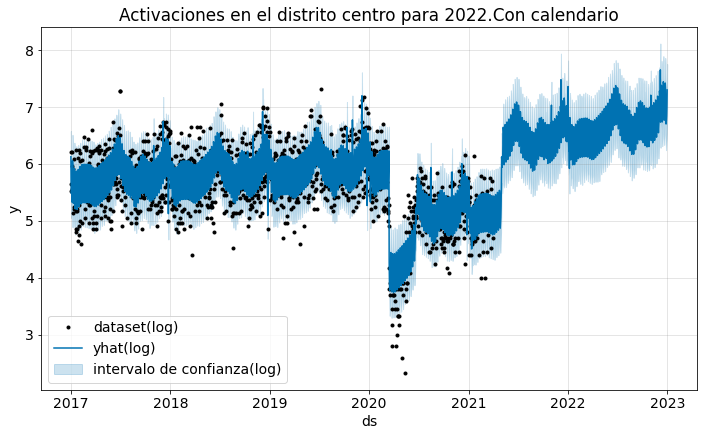

In [93]:
modelo6.plot(prediccion6)
plt.legend(["dataset(log)","yhat(log)","intervalo de confianza(log)"])
plt.title("Activaciones en el distrito centro para 2022.Con calendario");

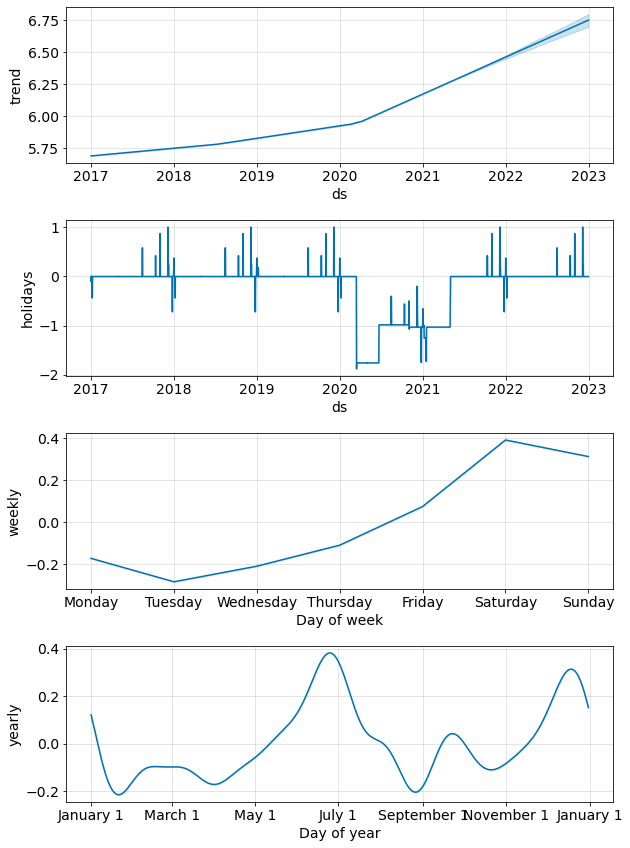

In [94]:
modelo6.plot_components(prediccion6, weekly_start=1);

### Transformación exponencial.

In [95]:
prediccion6["yhat"]=np.exp2(prediccion6["yhat"])

In [96]:
centro_pre_2022=prediccion6["yhat"][-365:].sum()

In [97]:
print(
    f"Las activaciones para el 2022 en el Distrito Centro serán {round(centro_pre_2022)} activaciones"
)

Las activaciones para el 2022 en el Distrito Centro serán 36726 activaciones


# Predicción de activaciones por distrito.

En esta apartado realizamos las predicciones de las activaciones por cada uno de los veinte y uno distritos de Madrid hasta final de  el año 2022. Todo el proceso de esta predicción se ha hecho en un solo bloque que contiene las siguientes fases.

## Preparación de los datos.
Creación de un dataframe  por cada distrito con la contabilización de sus activaciones pòr día.

## Transformación logarítmica.

Para evitar que el modelo pueda presentar en alguna predicción valores negativos,decidimos aplicar como primer paso una transformación logarítmica a los valores de las activaciones justo antes de hacer las predicciones con el modelo.

## Adaptar los datos para el modelo.

Se adapta cada dataframe por distrito para poder utlizarlo en el modelo renombrando sus columnas .

## Aplicación del modelo.

Una vez que hemos preparado los datos para nuestro modelo Prophet,nos toca entrenarlo y que prediga sucesivamente sobre cada uno de los dataframes con las activaciones de cada distrito. 
A cada una de las predicciones por distrito se le aplica una transformación exponencial 2 (valores yhat) para obtener los resultados finales.

In [98]:

distritos = list(df_emergencias["Distrito"].unique())

df_resultado_2022 = pd.DataFrame(index=distritos)
df_resultado_2021 = pd.DataFrame(index=distritos)
for distrito in distritos:
    distrito_df = df_emergencias[df_emergencias["Distrito"] == distrito]
    distrito_df = distrito_df.groupby("Fecha Activacion").agg(
        emergencias=("Distrito", "count"))
    distrito_df = np.log2(distrito_df)
    distrito_df = distrito_df.reset_index().dropna()
    distrito_df = distrito_df.rename(columns={
        "Fecha Activacion": "ds",
        "emergencias": "y"
    })
    modelo_dist = Prophet(holidays=dias_especiales)
    modelo_dist.add_country_holidays(country_name='ESP')
    prediccion_dist = modelo_dist.fit(distrito_df).predict(futuro_22)
    dist_df_pred = prediccion_dist.loc[:, ['ds', 'yhat']]
    dist_df_pred['yhat'] = np.exp2(dist_df_pred['yhat'])
    dist_df_pred_2022 = dist_df_pred.set_index(
        "ds").loc["2022-01-01":"2022-12-31"]
    dist_df_pred_2021 = dist_df_pred.set_index(
        "ds").loc["2021-01-01":"2021-12-31"]

    df_resultado_2022.loc[distrito, 'yhat'] = int(dist_df_pred_2022["yhat"].sum())
    df_resultado_2021.loc[distrito, 'yhat'] = int(dist_df_pred_2021["yhat"].sum())

df_resultado_2022 = df_resultado_2022.sort_values("yhat", ascending=False)
df_resultado_2021 = df_resultado_2021.sort_values("yhat", ascending=False)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [99]:
df_resultado_2022.head()

,yhat
Centro,36725.0
Carabanchel,11657.0
Puente de Vallecas,9808.0
Tetuán,9473.0
Salamanca,8884.0


In [100]:
df_resultado_2021.head()

,yhat
Centro,25569.0
Carabanchel,10213.0
Puente de Vallecas,8753.0
Tetuán,7988.0
Latina,7799.0


## Presentación  y análisis de los resultados.

Una vez obtenidas todas las predicciones que nos hemos propuesto,presentamos los resultados en diagramas de barras.

### Resultados por Distritos.

In [101]:
df_merged_pred_dist = pd.merge(df_resultado_2022,
                          df_resultado_2021,
                          right_index=True,
                          left_index=True,
                          how="outer")
df_merged_pred_dist=df_merged_pred_dist.rename(columns={
    "yhat_x": "activaciones_2022",
    "yhat_y": "activaciones_2021"
})
df_merged_pred_dist=df_merged_pred_dist.sort_values("activaciones_2022", ascending=False)
df_merged_pred_dist.head()

,activaciones_2022,activaciones_2021
Centro,36725.0,25569.0
Carabanchel,11657.0,10213.0
Puente de Vallecas,9808.0,8753.0
Tetuán,9473.0,7988.0
Salamanca,8884.0,7466.0


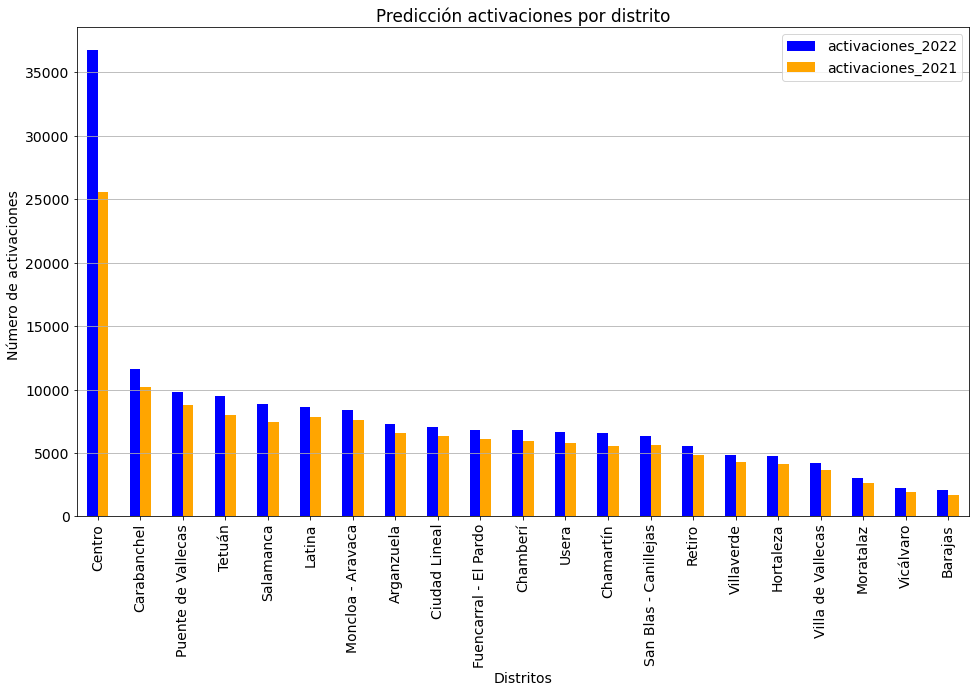

In [102]:
df_merged_pred_dist.plot(kind="bar",color=["blue","orange"])
plt.grid(axis="y")
plt.ylabel("Número de activaciones ")
plt.xlabel("Distritos")
plt.title("Predicción activaciones por distrito")
plt.xticks(ticks=range(0,21),labels=df_merged_pred_dist.index);

### Resultados totales.

In [103]:
#Se obtiene el total de activaciones de 2017,2018,2019,2020,2021
total_2017 = df_timeseries_emergencias["Fecha Activacion"].loc[
    "2017-01-01":"2017-12-31"].count()
total_2018 = df_timeseries_emergencias["Fecha Activacion"].loc[
    "2018-01-01":"2018-12-31"].count()
total_2019 = df_timeseries_emergencias["Fecha Activacion"].loc[
    "2019-01-01":"2019-12-31"].count()
total_2020=df_timeseries_emergencias["Fecha Activacion"].loc[
    "2020-01-01":"2020-12-31"].count()

In [104]:
# Con la predicción de Prophet para el resto de 2021 y el acumulado que llevábamos en el 2021
total_pre_2021 
print(
    f"la predicción total de activaciones para el 2021 son de {round(total_pre_2021)} activaciones"
)

la predicción total de activaciones para el 2021 son de 137546 activaciones


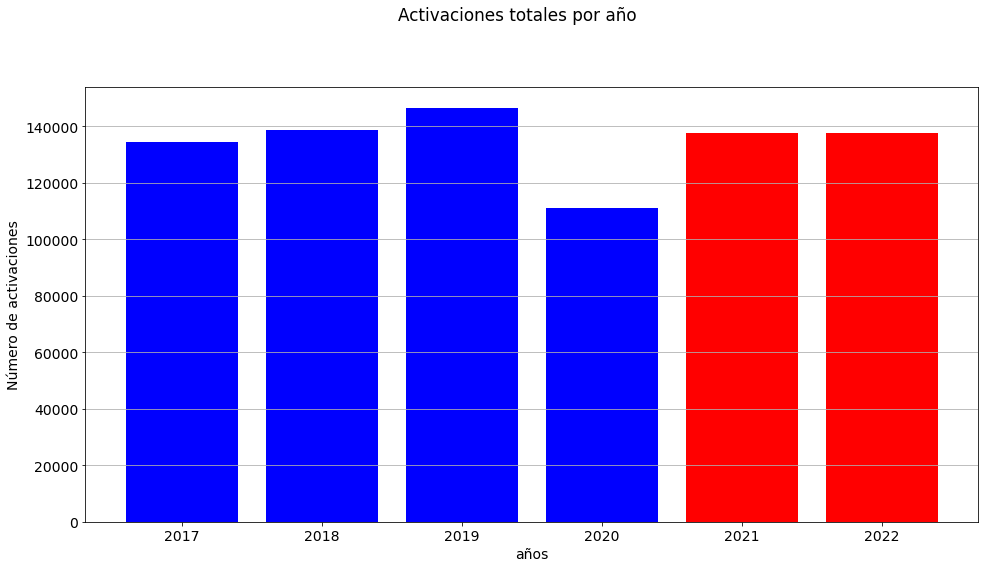

In [105]:
#Se realiza diagrama de barras de todas las activaciones de todos los años que disponemos
fig, ax = plt.subplots(figsize=(16,8))
x = [2017, 2018, 2019, 2020, 2021, 2022]
ax.bar(x=x,
       height=[
           total_2017, total_2018, total_2019, total_2020, total_pre_2021,
           total_pre_2022
       ],color=["b","b","b","b","r","r"])
ax.grid(True, axis='y')
ax.set_xticks(x)
ax.set_xlabel("años")    
ax.set_ylabel('Número de activaciones');
fig.suptitle('Activaciones totales por año', y=1.02);

### Resultados distrito Centro.

In [106]:
#Se guardan los valores de cada año
centro_2017=df_timeseries_emergencias[df_timeseries_emergencias["Distrito"] ==
                          "Centro"].loc["2017"]["Fecha Activacion"].count()
centro_2018=df_timeseries_emergencias[df_timeseries_emergencias["Distrito"] ==
                          "Centro"].loc["2018"]["Fecha Activacion"].count()
centro_2019=df_timeseries_emergencias[df_timeseries_emergencias["Distrito"] ==
                          "Centro"].loc["2019"]["Fecha Activacion"].count()
centro_2020=df_timeseries_emergencias[df_timeseries_emergencias["Distrito"] ==
                          "Centro"].loc["2020"]["Fecha Activacion"].count()
centro_2021=df_merged_pred_dist.iloc[:,1]["Centro"]
centro_2022=df_merged_pred_dist.iloc[:,0]["Centro"]

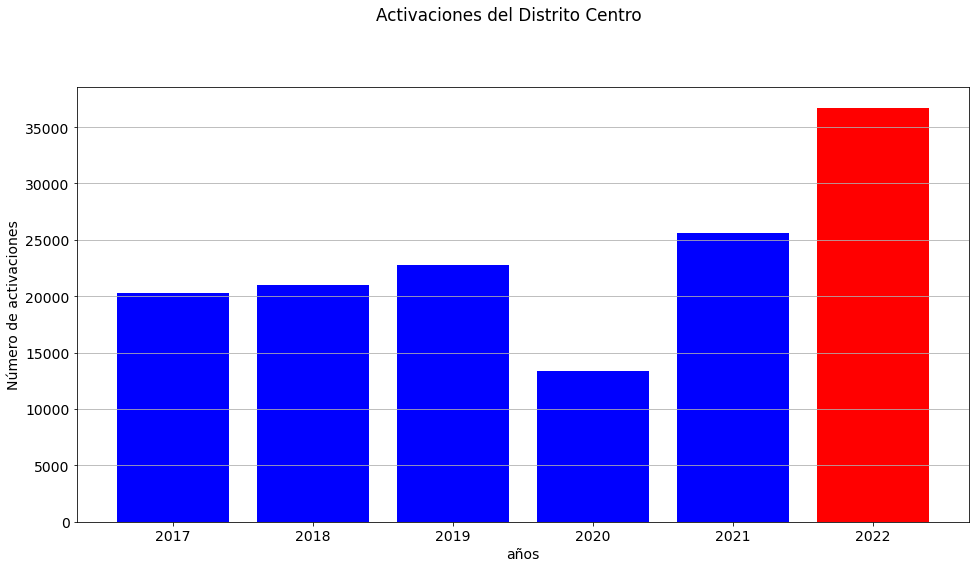

In [107]:
#Se realiza diagrama de barras de los resultados del distrito Centro
fig, ax = plt.subplots(figsize=(16, 8))
x = [
    2017,2018,2019,2020,2021,2022
]
ax.bar(x=x,
       height=[
           centro_2017, centro_2018, centro_2019, centro_2020, centro_2021,
    centro_2022

       ],
       color=["b", "b", "b", "b", "b", "r"])
ax.grid(True, axis='y')
ax.set_xticks(x)
ax.set_xlabel("años")
ax.set_ylabel('Número de activaciones')
fig.suptitle('Activaciones del Distrito Centro', y=1.02);

### Resultados del Distrito Barajas.

In [108]:
barajas_2017=df_timeseries_emergencias[df_timeseries_emergencias["Distrito"] ==
                          "Barajas"].loc["2017"]["Fecha Activacion"].count()
barajas_2018=df_timeseries_emergencias[df_timeseries_emergencias["Distrito"] ==
                          "Barajas"].loc["2018"]["Fecha Activacion"].count()
barajas_2019=df_timeseries_emergencias[df_timeseries_emergencias["Distrito"] ==
                          "Barajas"].loc["2019"]["Fecha Activacion"].count()
barajas_2020=df_timeseries_emergencias[df_timeseries_emergencias["Distrito"] ==
                          "Barajas"].loc["2020"]["Fecha Activacion"].count()
barajas_2021=df_merged_pred_dist.iloc[:,1]["Barajas"]
barajas_2022=df_merged_pred_dist.iloc[:,0]["Barajas"]

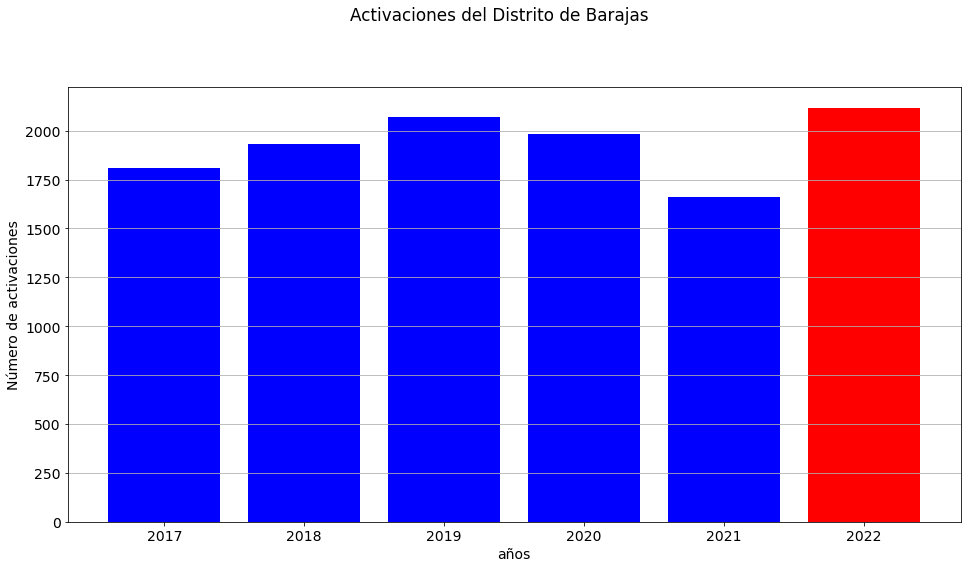

In [109]:
#Se realiza diagrama de barras de los resultados del distrito Centro
fig, ax = plt.subplots(figsize=(16, 8))
x = [2017, 2018, 2019, 2020, 2021, 2022]

ax.bar(x=x,
       height=[
            barajas_2017,  barajas_2018, 
           barajas_2019, barajas_2020, barajas_2021,
            barajas_2022
       ],
       color=["b","b","b","b","b","r"])

ax.grid(True, axis='y')
ax.set_xticks(x)
ax.set_xlabel("años")
ax.set_ylabel('Número de activaciones')
fig.suptitle('Activaciones del Distrito de Barajas', y=1.02);

### Resultados por activaciones tipo.

In [110]:
#Se calculan los totales de este tipo de activación hasta 2022
df_emerg_casual = df_emergencias[df_emergencias["Código"] ==
                                 "Casual: caída, etc"]
df_emerg_casual_TimeSeries=df_emerg_casual.set_index("Fecha Activacion",drop=True)
total_caidas_2017=df_emerg_casual_TimeSeries.loc["2017"]["Código"].count()
total_caidas_2018=df_emerg_casual_TimeSeries.loc["2018"]["Código"].count()
total_caidas_2019=df_emerg_casual_TimeSeries.loc["2019"]["Código"].count()
total_caidas_2020=df_emerg_casual_TimeSeries.loc["2020"]["Código"].count()
total_caidas_2021=int(prediccion3[["ds","yhat"]].set_index("ds").loc["2021"].sum())
total_caidas_2022=int(prediccion3["yhat"][-365:].sum())

In [111]:
#Se calculan los totales  de este tipo de activación hasta 2022
df_emerg_cardio = df_emergencias[df_emergencias["Código"] ==
                                 "Patología cardiovascular"]
df_emerg_cardio_TimeSeries=df_emerg_cardio.set_index("Fecha Activacion",drop=True)
total_cardio_2017=df_emerg_cardio_TimeSeries.loc["2017"]["Código"].count()
total_cardio_2018=df_emerg_cardio_TimeSeries.loc["2018"]["Código"].count()
total_cardio_2019=df_emerg_cardio_TimeSeries.loc["2019"]["Código"].count()
total_cardio_2020=df_emerg_cardio_TimeSeries.loc["2020"]["Código"].count()
total_cardio_2021=int(prediccion4[["ds","yhat"]].set_index("ds").loc["2021"].sum())
total_cardio_2022=int(prediccion4["yhat"][-365:].sum())

In [112]:
lista_caidas_totales=[ total_caidas_2017,  total_caidas_2018, 
           total_caidas_2019,total_caidas_2020,total_caidas_2021,
            total_caidas_2022]
lista_cardio_totales=[ total_cardio_2017,  total_cardio_2018, 
           total_cardio_2019,total_cardio_2020,total_cardio_2021,
            total_cardio_2022]
lista_años=[2017, 2018, 2019, 2020, 2021, 2022]
data_caidas=dict(zip(lista_años,lista_caidas_totales))
data_cardio=dict(zip(lista_años,lista_cardio_totales))

In [113]:
# Se crea dataframe con columnas para tipo de activación con valores NaN
df_tipos = pd.DataFrame(columns=["tipo_caidas", "tipo_cardiovascular"],
                        index=lista_años)

df_tipos.head()

,tipo_caidas,tipo_cardiovascular
2017,NaN,NaN
2018,NaN,NaN
2019,NaN,NaN
2020,NaN,NaN
2021,NaN,NaN


In [114]:
df_tipos["tipo_caidas"] = df_tipos["tipo_caidas"].fillna(data_caidas)
df_tipos["tipo_cardiovascular"] = df_tipos["tipo_cardiovascular"].fillna(data_cardio)
df_tipos

,tipo_caidas,tipo_cardiovascular
2017,23309,23878
2018,23879,23462
2019,24758,25639
2020,17375,15227
2021,17750,28749
2022,13655,42368


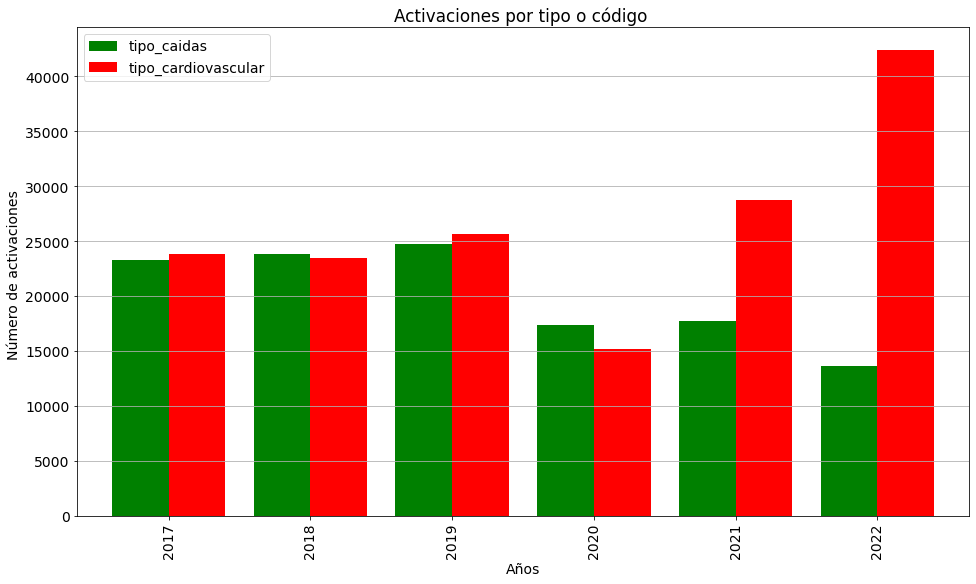

In [115]:
# Se plotea en diagrama de barras para representar los valores
df_tipos.plot(kind="bar",
        width=0.8,
        color=["g","r"])
plt.grid(axis="y")
plt.ylabel("Número de activaciones ")
plt.xlabel("Años")
plt.title("Activaciones por tipo o código ");

# Conclusiones.

Los resultados que el modelo presenta en las activaciones totales para el 2021 y 2022 son prácticamente los mismos alcanzando niveles de prepandemia.

En el apartado de las predicciones por tipos de activación se aprecia que suben las activaciones por patología cardiovascular para el 2022, y las casuales, caídas,etc. descienden.Ambas activaciones se han predicho con un calendario distinto en la aplicación del modelo por sus características diferentes.

Por último, los resultados de las activaciones por distritos, predicen subidas en los distritos marcando el mayor número en el distrito Centro y el menor en el de Barajas. En este sentido, la distribución de activaciones por distrito no cambia.

Tenemos que señalar, que los resultados de una predicción se ven afectados por la configuración del calendario que le hayamos aplicado al modelo Prophet y según el tipo de predicción que estemos haciendo. El objetivo de esta parte del proyecto emergencias era dar unos resultados en forma de  predicciones  que fueran lo suficientemente razonables.

# Exportación de los resultados.

In [116]:
#Se cambia el nombre de la columna
df_resultado_2022_exp = df_resultado_2022.reset_index().rename(columns={
    "index": "Distritos",
    "yhat": "activaciones"
})
df_resultado_2022_exp.head()

,Distritos,activaciones
0,Centro,36725.0
1,Carabanchel,11657.0
2,Puente de Vallecas,9808.0
3,Tetuán,9473.0
4,Salamanca,8884.0


In [117]:
#Se guardan los resultados de las predicciones en un archivo csv
df_resultado_2022_exp.to_csv("./datos/prediccion_2022.csv",
                    sep=";",
                    encoding="iso8859",index=False)

In [118]:
#Se comprueba que la lectura del fichero es la correcta
pd.read_csv("./datos/prediccion_2022.csv",sep=";",encoding="iso8859")

,Distritos,activaciones
0,Centro,36725.0
1,Carabanchel,11657.0
2,Puente de Vallecas,9808.0
3,Tetuán,9473.0
4,Salamanca,8884.0
5,Latina,8631.0
6,Moncloa - Aravaca,8360.0
7,Arganzuela,7293.0
8,Ciudad Lineal,7060.0
9,Chamberí,6848.0
